<a href="https://colab.research.google.com/github/AlbertP97/Bitcoin-price-prediction/blob/main/LSTM_Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pyyaml h5py Required to save models in HDF5 format
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, ReLU, Dropout

from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/Evolutionary Computing/Proyecto Final/'
data = pd.read_csv(path + 'BTC-USD.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Imprimiendo los precios del Bitcoin a lo largo de los años**

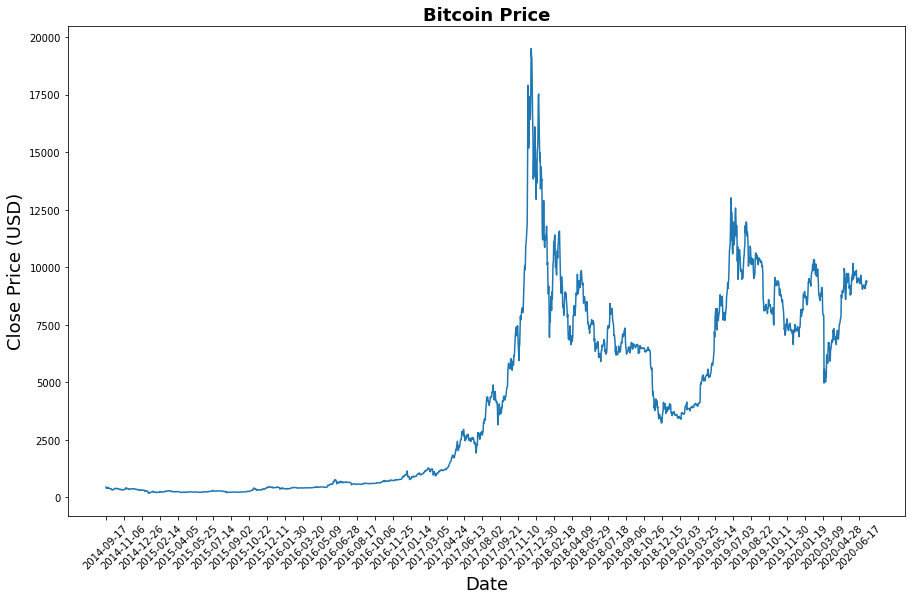

In [ ]:
price = data[['Close']]

plt.figure(figsize = (15, 9))
plt.plot(price)
plt.xticks(range(0, data.shape[0], 50), data['Date'].loc[::50], rotation=45)
plt.title("Bitcoin Price", fontsize=18, fontweight='bold')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price (USD)", fontsize=18)
plt.show()

**Preprocesamiento y normalizacion de los datos**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(price.values)

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    index = range(i-history_size, i)
    data.append(np.reshape(dataset[index], (history_size, 1)))
    labels.append(dataset[i+target_size])

  return np.array(data), np.array(labels)

**Dividiendo el dataset en set de entrenamiento y de prueba**

In [ ]:
past_history = 5
future_target = 0

TRAIN_SPLIT = int(len(data_scaled) * 0.8)

X_train, y_train = univariate_data(data_scaled,
                                   0,
                                   TRAIN_SPLIT,
                                   past_history,
                                   future_target)

X_test, y_test = univariate_data(data_scaled,
                                 TRAIN_SPLIT,
                                 None,
                                 past_history,
                                 future_target)

X_train.shape

(1693, 5, 1)

**Configuracion y entrenamiento de la red LSTM**

In [ ]:
num_units = 40
lr = 0.0001
activation_function = 'relu'
adam = Adam(lr=lr)
loss_function = 'mse'
batch_size = 32
epochs = 50

model = Sequential()

# LSTM layer
model.add(LSTM(units=num_units, activation=activation_function, input_shape=(None, 1)))
model.add(ReLU())
model.add(Dropout(0.1))

# Output layer
model.add(Dense(units = 1))

model.compile(optimizer=adam, loss=loss_function)
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                6720      
                                                                 
 re_lu (ReLU)                (None, 40)                0         
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,
                    y_train,
                    validation_split=0.1,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=False)

Epoch 1/50
48/48 [==============================] - 4s 17ms/step - loss: 0.0684 - val_loss: 0.0468
Epoch 2/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0637 - val_loss: 0.0411
Epoch 3/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0593 - val_loss: 0.0360
Epoch 4/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0552 - val_loss: 0.0317
Epoch 5/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0513 - val_loss: 0.0280
Epoch 6/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0482 - val_loss: 0.0248
Epoch 7/50
48/48 [==============================] - 1s 21ms/step - loss: 0.0451 - val_loss: 0.0220
Epoch 8/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0419 - val_loss: 0.0194
Epoch 9/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0395 - val_loss: 0.0173
Epoch 10/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0373 - val_loss: 0.0154
Epoch 11/

**Guardando pesos del modelo**

In [ ]:
model.save_weights("/content/drive/MyDrive/Evolutionary Computing/Proyecto Final/weights.h5")

**Validacion de los resultados**

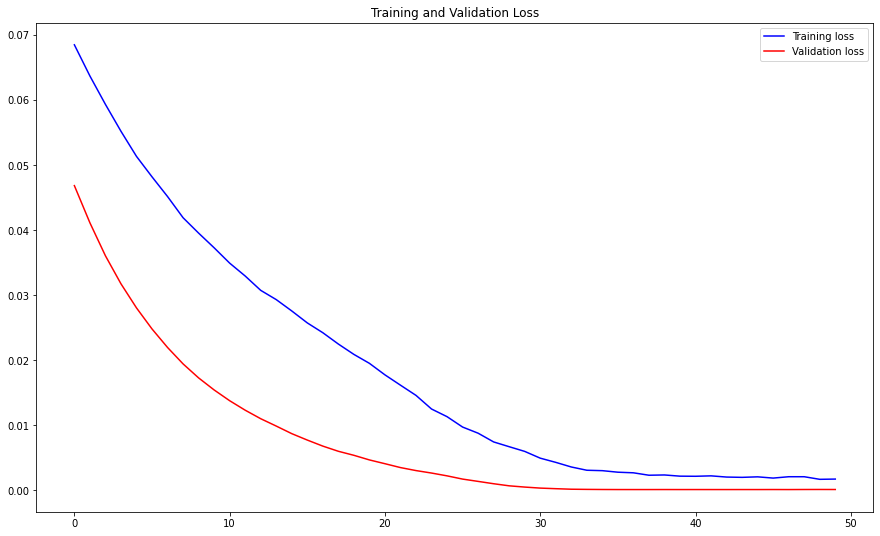

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize = (15, 9))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

**Prediccion del modelo en el set de entrenamiento**

[]

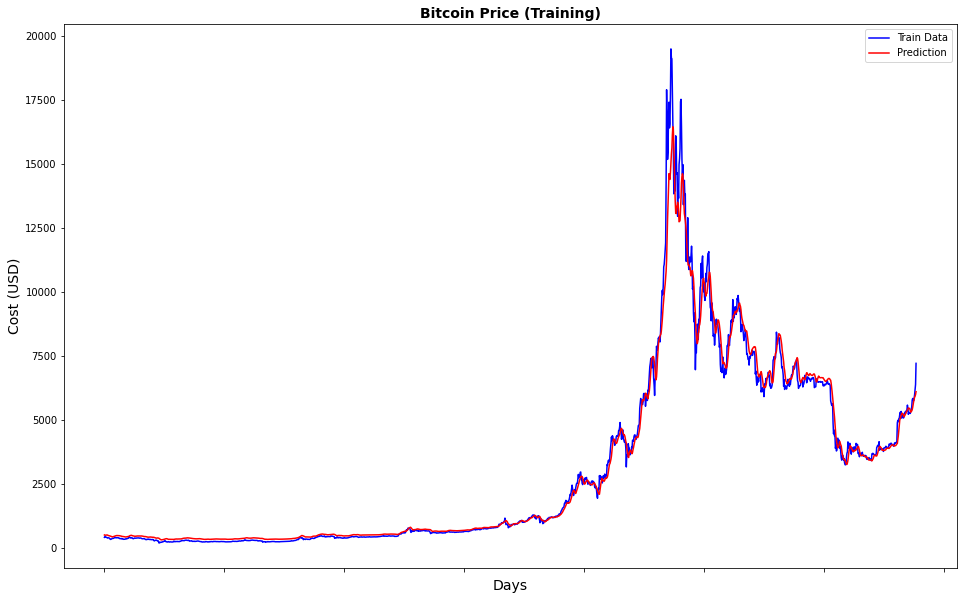

In [ ]:
import seaborn as sns
from matplotlib import rcParams

train = pd.DataFrame(scaler.inverse_transform(y_train))
train_predictions = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)))

rcParams['figure.figsize'] = 16, 10
p = sns.lineplot()
ax = sns.lineplot(x=train.index, y=train[0], label="Train Data", color='blue')
ax = sns.lineplot(x=train_predictions.index, y=train_predictions[0], label="Prediction", color='red')
ax.set_title("Bitcoin Price (Training)", size = 14, fontweight = "bold")
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size = 10)

**Prediccion del modelo en el set de prueba**

[]

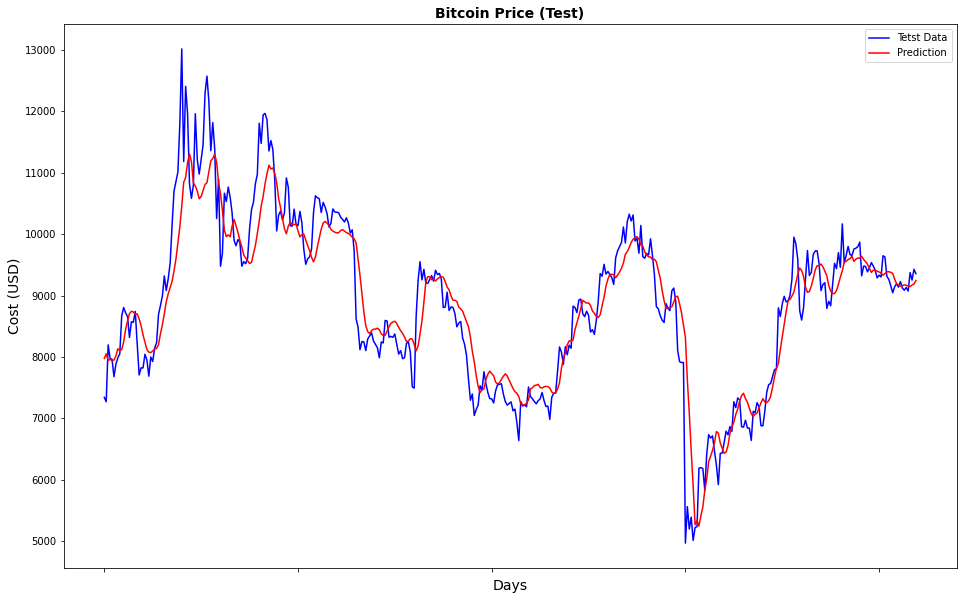

In [ ]:
original = pd.DataFrame(scaler.inverse_transform(y_test))
predictions = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)))

rcParams['figure.figsize'] = 16, 10
p = sns.lineplot()
ax = sns.lineplot(x=original.index, y=original[0], label="Tetst Data", color='blue')
ax = sns.lineplot(x=predictions.index, y=predictions[0], label="Prediction", color='red')
ax.set_title("Bitcoin Price (Test)", size = 14, fontweight = "bold")
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size = 10)

**Desempeño en el set de entrenamiento**

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import math

rnn_train_pred = model.predict(X_train)
train_score =  math.sqrt(mean_squared_error(y_train, rnn_train_pred))
print("Error en train: % .2f RMSE" % (train_score))
print("Desempeño en el train: ", r2_score(y_train, rnn_train_pred))

Error en train:  0.02 RMSE
Desempeño en el train:  0.9821864976568322


**Desempeño en el set de prueba**

In [ ]:
rnn_test_pred = model.predict(X_test)
test_score = math.sqrt(mean_squared_error(y_test, rnn_test_pred))
print("Error en test: % .2f RMSE" % (test_score))
print("Desempeño en el test: ", r2_score(y_test, rnn_test_pred))

Error en test:  0.03 RMSE
Desempeño en el test:  0.8564417063636549


**Optimizacion y entrenamiento de la red LSTM con algoritmos geneticos**

In [ ]:
"""
Hiperparametros a optimizar
Batch size = 10, 20, 40, 60, 80, 100
Epcohes =  10, 50, 100
Optimization = SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
Drop regularization = 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
Neurons in hidden layer = 1, 5, 10, 15, 20, 25, 30
"""
# Restore the weights
model.load_weights("/content/drive/MyDrive/Evolutionary Computing/Proyecto Final/weights.h5")

In [ ]:
!pip install deap

     |████████████████████████████████| 160 kB 5.3 MB/s 


In [ ]:
!pip install bitstring

**Creando el algoritmo genetico**

In [ ]:
from datetime import datetime
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from sklearn.model_selection import train_test_split

def train_evaluate(ga_individual_solution):
    # Decode GA solution to integer for num_neurons1, epochs and batch_size
    num_neurons1_bits = BitArray(ga_individual_solution[0:9])
    num_neurons2_bits = BitArray(ga_individual_solution[9:18])
    epoch_bits = BitArray(ga_individual_solution[18:25])
    batch_size_bits = BitArray(ga_individual_solution[25:35])
    learning_rate_bits = BitArray(ga_individual_solution[35:])

    num_neurons1 = num_neurons1_bits.uint
    num_neurons2 = num_neurons2_bits.uint
    epoch = epoch_bits.uint
    Batch_size = batch_size_bits.uint
    temp = learning_rate_bits.uint
    learning_rate = temp*(math.exp(-9))

    print('\nNum of neurons1: ', num_neurons1,'\nNum of neurons2',num_neurons2, '\nEpoch:', epoch,'\nBatch size:',Batch_size,'\nLearning rate:',learning_rate)

    # Return fitness score of 100 if window_size or num_unit is zero
    if num_neurons1 < 100 or num_neurons2 < 100 or epoch < 100 or Batch_size < 500  or learning_rate < 0:
      return 0,

    rnn_test_pred = model.predict(X_test)
    test_score = np.sqrt(mean_squared_error(y_test, rnn_test_pred))
    print("Error: % .2f RMSE" % (test_score))
    print("Desempeño: ", r2_score(y_test, rnn_test_pred))

    return test_score,

**Implememntando el algoritmo genetico en la red LSTM para la busqueda de los mejores hiperparametros**

In [ ]:
population_size = 200
num_generations = 200
gene_length = 42

# As we are trying to minimize the RMSE score, that's why using -1.0.
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
start_time = datetime.now()
print("Start time:", start_time)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.3, ngen = num_generations, verbose = False)
end_time = datetime.now()
print('End time:',end_time)
time_elapsed = end_time-start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Se han truncado las últimas 5000 líneas del flujo de salida.
Num of neurons2 511 
Epoch: 127 
Batch size: 1023 
Learning rate: 0.015673045119008303
Error:  0.03 RMSE
Desempeño:  0.8564417063636549

Num of neurons1:  511 
Num of neurons2 511 
Epoch: 127 
Batch size: 1023 
Learning rate: 0.015673045119008303
Error:  0.03 RMSE
Desempeño:  0.8564417063636549

Num of neurons1:  511 
Num of neurons2 511 
Epoch: 127 
Batch size: 1023 
Learning rate: 0.015673045119008303
Error:  0.03 RMSE
Desempeño:  0.8564417063636549

Num of neurons1:  511 
Num of neurons2 511 
Epoch: 127 
Batch size: 1023 
Learning rate: 0.015673045119008303
Error:  0.03 RMSE
Desempeño:  0.8564417063636549

Num of neurons1:  511 
Num of neurons2 511 
Epoch: 127 
Batch size: 1023 
Learning rate: 0.015673045119008303
Error:  0.03 RMSE
Desempeño:  0.8564417063636549

Num of neurons1:  511 
Num of neurons2 511 
Epoch: 127 
Batch size: 1023 
Learning rate: 0.015673045119008303
Error:  0.03 RMSE
Desempeño:  0.8564417063636549

Nu

**Mostrando los mejores hiperparametros obtenidos del algoritmo genetico**

In [ ]:
best_individuals = tools.selBest(population,k = 1)
best_num_neurons1 = None
best_num_neurons2 = None
best_epoch = None
best_batch_size = None
best_learning_rate = None

for bi in best_individuals:
    num_neurons1_bits = BitArray(bi[0:9])
    num_neurons2_bits = BitArray(bi[9:18])
    epoch_bits = BitArray(bi[18:25])
    batch_size_bits = BitArray(bi[25:35])
    learning_rate_bits = BitArray(bi[35:])

    best_num_neurons1 = num_neurons1_bits.uint
    best_num_neurons2 = num_neurons2_bits.uint
    best_epoch = epoch_bits.uint
    best_batch_size = batch_size_bits.uint
    temp = learning_rate_bits.uint
    best_learning_rate = temp*(math.exp(-9))
    print('\nNum of neurons1: ', best_num_neurons1, '\nNum of neurons2: ', best_num_neurons2,  '\nEpoch:', best_epoch, '\nBatch_size:', best_batch_size, '\nLearning rate:', best_learning_rate)


Num of neurons1:  511 
Num of neurons2:  511 
Epoch: 127 
Batch_size: 1023 
Learning rate: 0.015673045119008303


**Dvidiendo el dataset de nuevo**

In [ ]:
past_history = 5
future_target = 0

TRAIN_SPLIT = int(len(data_scaled) * 0.8)

X_train, y_train = univariate_data(data_scaled,
                                   0,
                                   TRAIN_SPLIT,
                                   past_history,
                                   future_target)

X_test, y_test = univariate_data(data_scaled,
                                 TRAIN_SPLIT,
                                 None,
                                 past_history,
                                 future_target)

X_train.shape

(1693, 5, 1)

**Implementando la red LSTM con los hiperparametros obtenidos por el algoritmo genetico**

In [ ]:
num_units = 40
lr = 0.015673045119008303
activation_function = 'relu'
adam = Adam(lr=lr)
loss_function = 'mse'
batch_size = 510
epochs = 127

model = Sequential()

# LSTM layer
model.add(LSTM(units=num_units, activation=activation_function, input_shape=(None, 1)))
model.add(ReLU())
model.add(Dropout(0.1))

# Output layer
model.add(Dense(units = 1))

model.compile(optimizer=adam, loss=loss_function)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 40)                6720      
                                                                 
 re_lu_1 (ReLU)              (None, 40)                0         
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Corriendo el modelo**

In [ ]:
history = model.fit(X_train,
                    y_train,
                    validation_split=0.1,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=False)

Epoch 1/127
3/3 [==============================] - 1s 122ms/step - loss: 0.0382 - val_loss: 0.0120
Epoch 2/127
3/3 [==============================] - 0s 29ms/step - loss: 0.0271 - val_loss: 0.0036
Epoch 3/127
3/3 [==============================] - 0s 22ms/step - loss: 0.0224 - val_loss: 9.5727e-04
Epoch 4/127
3/3 [==============================] - 0s 20ms/step - loss: 0.0196 - val_loss: 7.9024e-04
Epoch 5/127
3/3 [==============================] - 0s 24ms/step - loss: 0.0150 - val_loss: 5.9408e-04
Epoch 6/127
3/3 [==============================] - 0s 23ms/step - loss: 0.0095 - val_loss: 3.2403e-04
Epoch 7/127
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 8/127
3/3 [==============================] - 0s 22ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 9/127
3/3 [==============================] - 0s 22ms/step - loss: 0.0048 - val_loss: 0.0055
Epoch 10/127
3/3 [==============================] - 0s 20ms/step - loss: 0.0033 - val_loss: 0.0019
Ep

**Guardando los pesos del modelo con el Algoritmo Genetico**

In [ ]:
model.save_weights("/content/drive/MyDrive/Evolutionary Computing/Proyecto Final/GA_weights.h5")

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

[[0.38941675]
 [0.38486025]
 [0.37749693]
 [0.3865277 ]
 [0.38667846]
 [0.38836652]
 [0.3876351 ]
 [0.39169264]
 [0.39183673]
 [0.3937693 ]
 [0.40571713]
 [0.4173631 ]
 [0.42381832]
 [0.4276871 ]
 [0.42492503]
 [0.425248  ]
 [0.4240222 ]
 [0.42648077]
 [0.41896147]
 [0.40751204]
 [0.40061617]
 [0.39485866]
 [0.39294827]
 [0.39171678]
 [0.38884383]
 [0.39195448]
 [0.39252302]
 [0.3957256 ]
 [0.39957133]
 [0.41164106]
 [0.4210906 ]
 [0.43128312]
 [0.4436702 ]
 [0.44810778]
 [0.45355836]
 [0.46123362]
 [0.4768917 ]
 [0.49590224]
 [0.51300067]
 [0.5279252 ]
 [0.5526474 ]
 [0.58999205]
 [0.5768796 ]
 [0.5962982 ]
 [0.59799033]
 [0.57617706]
 [0.5540297 ]
 [0.54980147]
 [0.5620512 ]
 [0.5547738 ]
 [0.5520527 ]
 [0.55636525]
 [0.56282604]
 [0.57757765]
 [0.5945228 ]
 [0.599429  ]
 [0.58869505]
 [0.5916131 ]
 [0.580823  ]
 [0.5513801 ]
 [0.54618955]
 [0.51738423]
 [0.50154716]
 [0.507604  ]
 [0.51165855]
 [0.51624095]
 [0.52237284]
 [0.5222938 ]
 [0.5108621 ]
 [0.50248975]
 [0.4969749 ]
 [0.49

**Validacion de los resultados del modelo con optimizacion de hiperparametros por medio de algorimos geneticos**

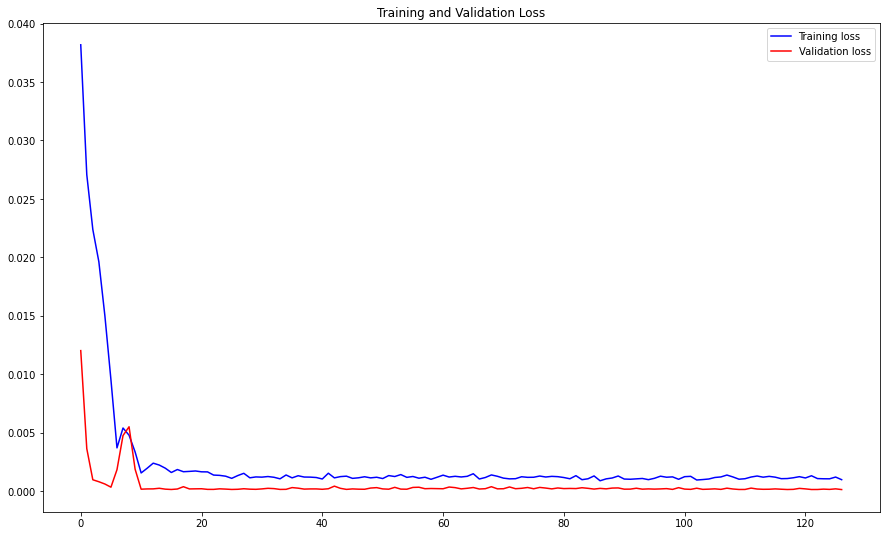

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize = (15, 9))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

**Prediccion del modelo con hiperparametros del AG en el set de prueba**

[]

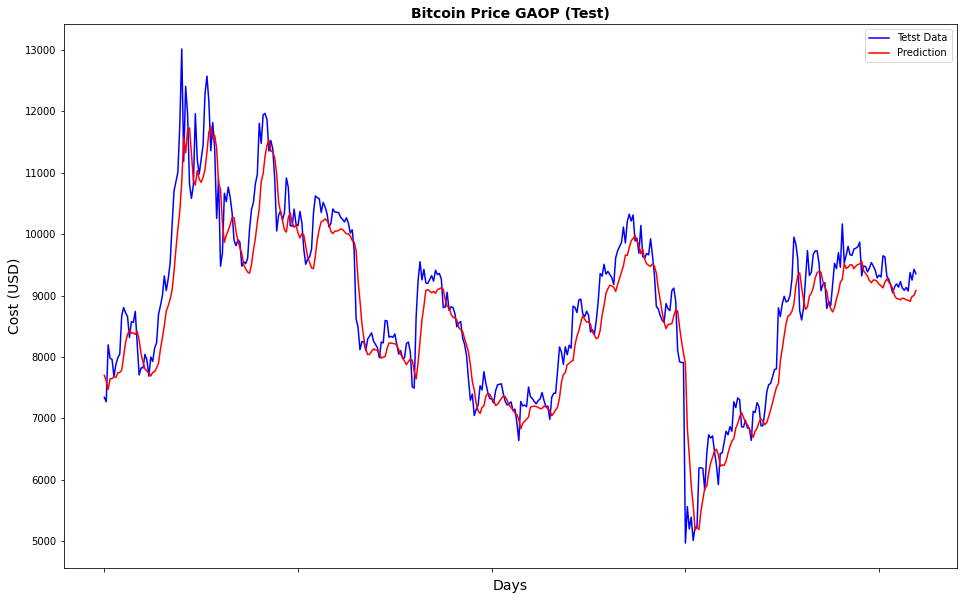

In [ ]:
original = pd.DataFrame(scaler.inverse_transform(y_test))
predictions = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)))

rcParams['figure.figsize'] = 16, 10
p = sns.lineplot()
ax = sns.lineplot(x=original.index, y=original[0], label="Tetst Data", color='blue')
ax = sns.lineplot(x=predictions.index, y=predictions[0], label="Prediction", color='red')
ax.set_title("Bitcoin Price GAOP (Test)", size = 14, fontweight = "bold")
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size = 10)

**Desempeño del modelo con optimizacion con AG**

In [ ]:
rnn_test_pred = model.predict(X_test)
test_score = math.sqrt(mean_squared_error(y_test, rnn_test_pred))
print("Error en test: % .2f RMSE" % (test_score))
print("Desempeño en el test: ", r2_score(y_test, rnn_test_pred))

Error en test:  0.03 RMSE
Desempeño en el test:  0.8801570531057192
